# Unsupervised learning

Unsupervised learning consists in creating a new type of label to predict on data that may or may not have been labelled initially. This new type a label could be a rotation angle for instance. This allows for the creation of custom weights that can serve as a good basis for the later "real" model training.

Note that the type of label used for unsupervised learning has to be selected somewhat carefully. For instance, rotations are useful when the "real" labels are expected to have specific orientations in the images (_e.g._, planes tend to be rather horizontal in images where they are on the ground). This label would not be useful for images where such orientations do not exist (_e.g._, most cellular microscopy images).

The data used for unsupervised learning should look similar to the data of interest, but does not have to match it perfectly, as real labels do not matter for this kind of learning.

In [31]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Tuple
from PIL import Image
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
import torchvision.datasets as datasets
import torchvision.models as models

from Trainer import ModelTrainer

In [2]:
# Directory to load/save datasets and models
data_dir = './datasets/'
if (not os.path.isdir(data_dir)):
    os.mkdir(data_dir)

model_dir = './models/'
if (not os.path.isdir(model_dir)):
    os.mkdir(model_dir)

# Device
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')

## Data preparation

In [12]:
class RotateSTL10(datasets.STL10):
    """
    Randomly rotate images.
    The final rand_int becomes the new label to predict.
    """

    # Angles in degrees
    # (Named all_perms for consistency with ShuffleSTL10 below)
    all_perms = [0, 45, 90, 135, 180, 225, 270]


    # Overwrite datasets.STL10's __getitem__ method
    def __getitem__(self, index: int) -> Tuple[Image.Image, int]:
        img = self.data[index]

        # Make sure image remains a PIL image after transposition
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        # Perform rotations with random angles from self.angles 
        rand_int = random.randint(0, len(self.all_perms) - 1)
        img = FT.rotate(img, angle=self.all_perms[rand_int])

        # Add other transforms post rotation
        if self.transform is not None:
            img = self.transform(img)

        return img, rand_int

In [37]:
# General image information
n_channels_in = 3  # Color images
pixel_size = 96

# Image transform
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [transforms.Resize(pixel_size),
     transforms.ToTensor(),
     transforms.Normalize(data_mean, data_std)]
)

# Loading MNIST dataset of handwritten digits with RotateSTL10
train_data = RotateSTL10(data_dir,
                         split='train+unlabeled',
                         download=True,
                         transform=transform)
test_data = RotateSTL10(data_dir,
                        split='test',
                        download=True,
                        transform=transform)

# Let us split the training set into train and validation sets
train_size = 0.9
n_samples_train = int(len(train_data)*train_size)
n_samples_val = len(train_data) - n_samples_train
train_data, val_data \
    = torch.utils.data.random_split(train_data,
                                    [n_samples_train, n_samples_val],
                                    generator=torch.Generator().manual_seed(42))

Files already downloaded and verified
Files already downloaded and verified


## Training model from scratch

First, let us train a ResNet from scratch, namely the ResNet18 Pytorch model, which consists of 18 layers. Note that the ImageNet dataset on which the ResNet18 model was trained has 1000 classes, but the STL-10 dataset only has 10, so we need to change the final fully connected layer.

In [38]:
# Randomly initialized weights
model_name = 'ResNet18_STL10_rotated'
res_net = models.resnet18(weights=None).to(device)

n_classes = len(train_data.dataset.all_perms)

# Replace final fully connected layer to match the number of classes in our dataset
n_features = res_net.fc.in_features
res_net.fc = nn.Linear(n_features, n_classes).to(device)

# Number of parameters
n_params = 0
for param in res_net.parameters():
    n_params += param.flatten().shape[0]
print(f'This model has {n_params:_} parameters')

This model has 11_180_103 parameters


In [26]:
# Set up model trainer
batch_size = 64
n_epochs = 30
learning_rate = 1e-4
start_from_checkpoint = False

model_trainer = ModelTrainer(model=res_net,
                             device=device,
                             loss_fun=nn.CrossEntropyLoss(),
                             batch_size=batch_size,
                             learning_rate=learning_rate,
                             save_dir=model_dir,
                             model_name=model_name,
                             start_from_checkpoint=start_from_checkpoint)

# Set up data
model_trainer.set_data(train_set=train_data,
                       val_set=val_data,
                       test_set=test_data)

# Learning-rate scheduler
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(model_trainer.optimizer,
                                                    T_max=n_epochs,
                                                    eta_min=0)
model_trainer.set_lr_schedule(lr_scheduler)

Starting from scratch
Number of training examples: 94500
Number of validation examples: 10500
Number of testing examples: 8000


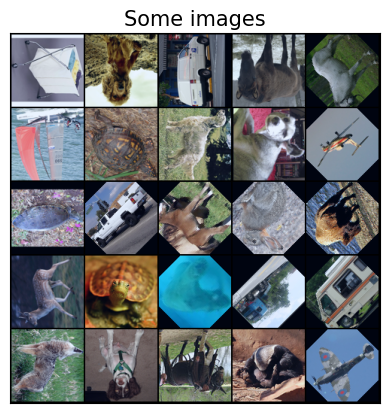

Ground-truth Labels:
[270, 180, 90, 180, 135]
[180, 180, 270, 270, 225]
[180, 45, 135, 225, 135]
[90, 0, 135, 225, 45]
[270, 180, 180, 0, 45]


In [27]:
# Let us visualize a few images
images, labels = next(iter(model_trainer.train_loader))

n_row = 5
out = torchvision.utils.make_grid(images[:n_row**2], nrow=n_row, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.tick_params(axis='both',
                which='both',
                left=False,
                labelleft=False,
                bottom=False,
                labelbottom=False)
plt.title('Some images', fontsize=15)
plt.show()

print('Ground-truth Labels:')
classes_plot = [train_data.dataset.all_perms[i] for i in labels.numpy().astype(int)]
count = 0
for i in range(n_row):
    start_idx = n_row*i
    end_idx = start_idx + n_row
    print(classes_plot[start_idx:end_idx])

In [28]:
start_time = time.time()
model_trainer.run_training(n_epochs=n_epochs)
end_time = time.time()

print(f'Highest validation accuracy: {100*model_trainer.best_valid_acc:.2f}%')
print(f'Training time: {(end_time - start_time):.2f} seconds')

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Training:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/1477 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/165 [00:00<?, ?it/s]

Highest validation accuracy: 85.13%
Training time: 5646.82 seconds


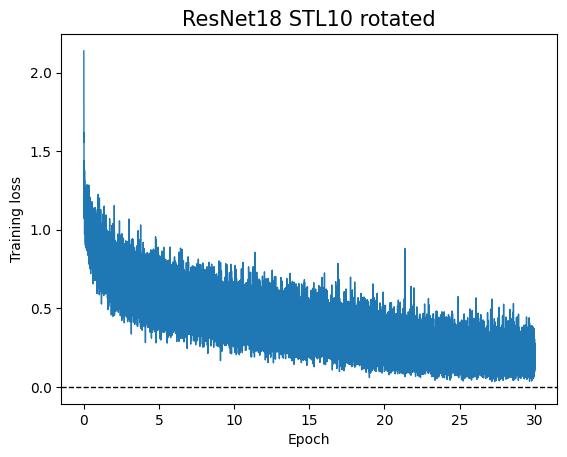

In [29]:
x_epoch = np.linspace(0, n_epochs, len(model_trainer.train_loss_logger))
plt.axhline(y=0, ls='--', color='k', lw=1)
plt.plot(x_epoch, model_trainer.train_loss_logger, lw=1)

xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title(model_name.replace('_', ' '), fontsize=15)
plt.show()

Evaluating Test Set:   0%|          | 0/125 [00:00<?, ?it/s]

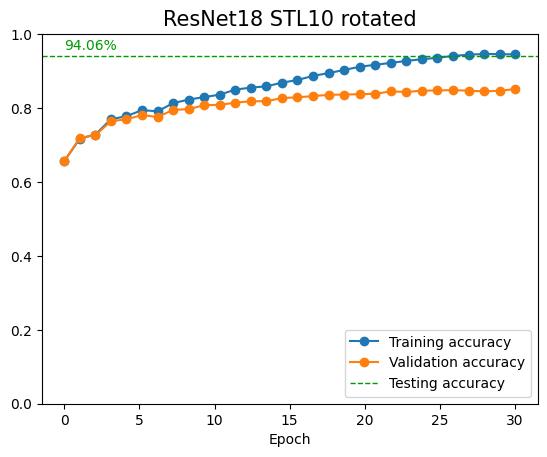

In [30]:
x_epoch = np.linspace(0, n_epochs, len(model_trainer.train_acc_logger))
plt.plot(x_epoch, model_trainer.train_acc_logger, marker='o', label='Training accuracy')

x_epoch = np.linspace(0, n_epochs, len(model_trainer.val_acc_logger))
plt.plot(x_epoch, model_trainer.val_acc_logger, marker='o', label='Validation accuracy')

testing_accuracy = model_trainer.evaluate_model(train_test_val='test')
plt.axhline(y=testing_accuracy, color=[0, 0.6, 0], ls='--', lw=1, label='Testing accuracy')
plt.text(0, 1.01*testing_accuracy, f'{100*testing_accuracy:.2f}%', color=[0, 0.6, 0], va='bottom')

plt.ylim([0, 1])
xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.title(model_name.replace('_', ' '), fontsize=15)
plt.show()

## Training on real labels

In [39]:
# General image information
classes = ('plane', 'bird', 'car', 'cat', 'deer',
           'dog', 'horse', 'monkey', 'ship', 'truck')
n_classes = len(classes)

# Image transform
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [transforms.Resize(pixel_size),
     transforms.ToTensor(),
     transforms.Normalize(data_mean, data_std)]
)

# Loading MNIST dataset of handwritten digits
train_data = datasets.STL10(data_dir,
                            split='train',
                            download=True,
                            transform=transform)
test_data = datasets.STL10(data_dir,
                           split='test',
                           download=True,
                           transform=transform)

# Let us split the training set into train and validation sets
train_size = 0.9
n_samples_train = int(len(train_data)*train_size)
n_samples_val = len(train_data) - n_samples_train
train_data, val_data \
    = torch.utils.data.random_split(train_data,
                                    [n_samples_train, n_samples_val],
                                    generator=torch.Generator().manual_seed(42))

Files already downloaded and verified
Files already downloaded and verified


In [40]:
# Load previous model and create new model from it
model_trainer = ModelTrainer(model=res_net,
                             device=device,
                             loss_fun=nn.CrossEntropyLoss(),
                             batch_size=batch_size,
                             learning_rate=learning_rate,
                             save_dir=model_dir,
                             model_name=model_name,
                             start_from_checkpoint=True)

model_name = model_name + '_pretrained'
model = deepcopy(model_trainer.model.to('cpu')).to(device)

n_features = model.fc.in_features
model.fc = nn.Linear(n_features, n_classes).to(device)

# Number of parameters
n_params = 0
for param in model.parameters():
    n_params += param.flatten().shape[0]
print(f'This model has {n_params:_} parameters')

Checkpoint loaded, starting from epoch: 29
This model has 11_181_642 parameters


In [41]:
# Set up model trainer
batch_size = 64
n_epochs = 30
learning_rate = 1e-4
start_from_checkpoint = False

model_trainer = ModelTrainer(model=model,
                             device=device,
                             loss_fun=nn.CrossEntropyLoss(),
                             batch_size=batch_size,
                             learning_rate=learning_rate,
                             save_dir=model_dir,
                             model_name=model_name,
                             start_from_checkpoint=start_from_checkpoint)

# Set up data
model_trainer.set_data(train_set=train_data,
                       val_set=val_data,
                       test_set=test_data)

# Learning-rate scheduler
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(model_trainer.optimizer,
                                                    T_max=n_epochs,
                                                    eta_min=0)
model_trainer.set_lr_schedule(lr_scheduler)

Starting from scratch
Number of training examples: 4500
Number of validation examples: 500
Number of testing examples: 8000


In [42]:
start_time = time.time()
model_trainer.run_training(n_epochs=n_epochs)
end_time = time.time()

print(f'Highest validation accuracy: {100*model_trainer.best_valid_acc:.2f}%')
print(f'Training time: {(end_time - start_time):.2f} seconds')

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Highest validation accuracy: 70.00%
Training time: 262.91 seconds


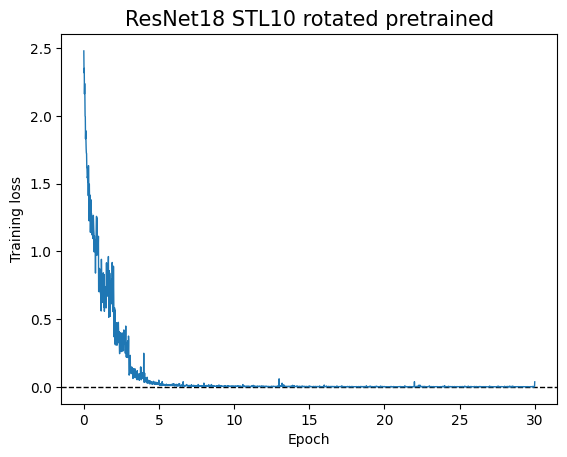

In [43]:
x_epoch = np.linspace(0, n_epochs, len(model_trainer.train_loss_logger))
plt.axhline(y=0, ls='--', color='k', lw=1)
plt.plot(x_epoch, model_trainer.train_loss_logger, lw=1)

xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title(model_name.replace('_', ' '), fontsize=15)
plt.show()

Evaluating Test Set:   0%|          | 0/125 [00:00<?, ?it/s]

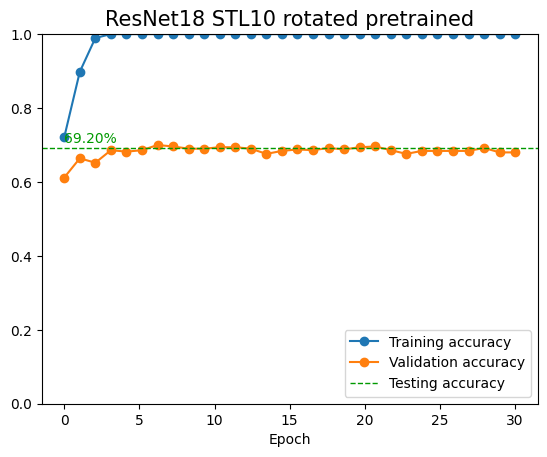

In [44]:
x_epoch = np.linspace(0, n_epochs, len(model_trainer.train_acc_logger))
plt.plot(x_epoch, model_trainer.train_acc_logger, marker='o', label='Training accuracy')

x_epoch = np.linspace(0, n_epochs, len(model_trainer.val_acc_logger))
plt.plot(x_epoch, model_trainer.val_acc_logger, marker='o', label='Validation accuracy')

testing_accuracy = model_trainer.evaluate_model(train_test_val='test')
plt.axhline(y=testing_accuracy, color=[0, 0.6, 0], ls='--', lw=1, label='Testing accuracy')
plt.text(0, 1.01*testing_accuracy, f'{100*testing_accuracy:.2f}%', color=[0, 0.6, 0], va='bottom')

plt.ylim([0, 1])
xticks_format = plt.FuncFormatter(lambda y, pos: f'{int(y)}')
plt.gca().xaxis.set_major_formatter(xticks_format)
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.title(model_name.replace('_', ' '), fontsize=15)
plt.show()

We achieve a ~8.4% increase in accuracy compared to a previous attempt at classifying this dataset without unsuperviserd learning (done outside of this notebook).